<a href="https://colab.research.google.com/github/mimjamam/cvpr/blob/main/mobileNetCelebData1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

Essential libraries for data manipulation, plotting, and building a machine learning model:
- **os**: Interact with the operating system
- **pickle**: Serialize and deserialize objects
- **matplotlib.pyplot**: Plotting graphs and images
- **numpy**: Numerical operations on arrays
- **tensorflow & keras**: Deep learning framework and its components
  - **keras.layers**: Building blocks of neural networks
  - **keras.optimizers**: Optimization algorithms like Adam
  - **MobileNet**: Pre-trained model
  - **Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization**: Neural network layers
  - **Model**: Define the model structure
  - **EarlyStopping, ModelCheckpoint**: Callbacks to improve training
  - **ImageDataGenerator**: Data augmentation during training

In [ ]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense , Dropout , BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Pickle

In [ ]:
load_dir = '/content/drive/MyDrive/DeepLearning/Transfer_Learning'

pickle_in = open(os.path.join(load_dir, "categories.pickle"), "rb")
categories = pickle.load(pickle_in)

pickle_in = open(os.path.join(load_dir, "X_train.pickle"), "rb")
X_train = pickle.load(pickle_in)

pickle_in = open(os.path.join(load_dir, "y_train.pickle"), "rb")
y_train = pickle.load(pickle_in)

pickle_in = open(os.path.join(load_dir, "X_valid.pickle"), "rb")
X_valid = pickle.load(pickle_in)

pickle_in = open(os.path.join(load_dir, "y_valid.pickle"), "rb")
y_valid = pickle.load(pickle_in)

pickle_in = open(os.path.join(load_dir, "X_test.pickle"), "rb")
X_test = pickle.load(pickle_in)

pickle_in = open(os.path.join(load_dir, "y_test.pickle"), "rb")
y_test = pickle.load(pickle_in)

### Data Augmentation with ImageDataGenerator  

- Applies transformations to images to enhance model generalization.  
- Includes rotation, shifting, shearing, zooming, and flipping.  
- `fill_mode='nearest'` fills in new pixels created by transformations.  


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

### Using MobileNet as a Base Model  

- Defines an input tensor of shape `(256, 256, 3)`.  
- Loads **MobileNet** pretrained on **ImageNet** without the top classification layer.  
- Allows transfer learning by using `input_tensor` for custom input size.  


In [ ]:
input_tensor = Input(shape=(256, 256, 3))

base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=input_tensor)

<ipython-input-5-6e3e40726d2b>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=input_tensor)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Fine-Tuning MobileNet & Adding Custom Layers  

- Unfreezes the last **20 layers** of **MobileNet** for fine-tuning.  
- Applies **GlobalAveragePooling2D** to reduce feature dimensions.  
- Uses **Dropout (0.8 & 0.2)** to minimize overfitting.  
- Adds a **256-unit Dense layer (ReLU activation)** for feature extraction.  
- Final **Dense layer (32 units, Softmax activation)** for multi-class classification.  


In [ ]:
for layer in base_model.layers[-20:]:
    layer.trainable = True


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.8)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(10, activation='softmax')(x)

### Compiling the Model & Early Stopping  

- **Defines the model** with MobileNet as the base and custom classification layers.  
- **Optimizer:** Adam with a learning rate of **0.0004** for stable training.  
- **Loss Function:** `sparse_categorical_crossentropy` for multi-class classification with integer labels.  
- **Metric:** Tracks **accuracy** during training.  
- **Early Stopping:** Monitors `val_accuracy`, stops training after **10 epochs** of no improvement, and restores the best weights.  


In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0004), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

### Training the Model  

- **Epochs:** Increased to **150** for better learning.  
- **Uses Data Augmentation:** `datagen.flow()` applies transformations during training.  
- **Batch Size:** **32** samples per batch.  
- **Validation Data:** `(X_valid, y_valid)` to monitor generalization.  
- **Verbose:** `1` for detailed training progress.  
- **Early Stopping:** Stops training if `val_accuracy` doesn't improve for **10 epochs**.  


In [ ]:
EPOCHS = 150


history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_valid, y_valid),
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.1012 - loss: 4.2762

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 256, 256, 3))
  warnings.warn(msg)


20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 607ms/step - accuracy: 0.1030 - loss: 4.2457 - val_accuracy: 0.1000 - val_loss: 5.2467
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - accuracy: 0.2274 - loss: 2.6906 - val_accuracy: 0.1437 - val_loss: 3.8944
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 444ms/step - accuracy: 0.3519 - loss: 2.0895 - val_accuracy: 0.2875 - val_loss: 2.8576
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 530ms/step - accuracy: 0.4771 - loss: 1.5595 - val_accuracy: 0.4062 - val_loss: 2.1177
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 519ms/step - accuracy: 0.5790 - loss: 1.2309 - val_accuracy: 0.5125 - val_loss: 1.6261
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 433ms/step - accuracy: 0.6653 - loss: 0.9026 - val_accuracy: 0.6313 - val_loss: 1.1958
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 502ms/step - accuracy: 0.7694 - loss: 0.7438 - val_accuracy: 0.7500 - val_loss: 0.8025
Epoch 8/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 527ms/step - accuracy: 0.7877 - loss: 0.6131 - val_accuracy: 

### Training the Model  

- **Epochs:** Increased to **150** for better learning.  
- **Uses Data Augmentation:** `datagen.flow()` applies transformations during training.  
- **Batch Size:** **32** samples per batch.  
- **Validation Data:** `(X_valid, y_valid)` to monitor generalization.  
- **Verbose:** `1` for detailed training progress.  
- **Early Stopping:** Stops training if `val_accuracy` doesn't improve for **10 epochs**.

In [ ]:
loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8649 - loss: 0.5447
Validation Loss: 0.5085912942886353
Validation Accuracy: 0.8812500238418579


### Plot Training & Validation Performance


- **Accuracy Plot:** The first subplot shows training and validation accuracy over epochs.
- **Loss Plot:** The second subplot shows training and validation loss over epochs.

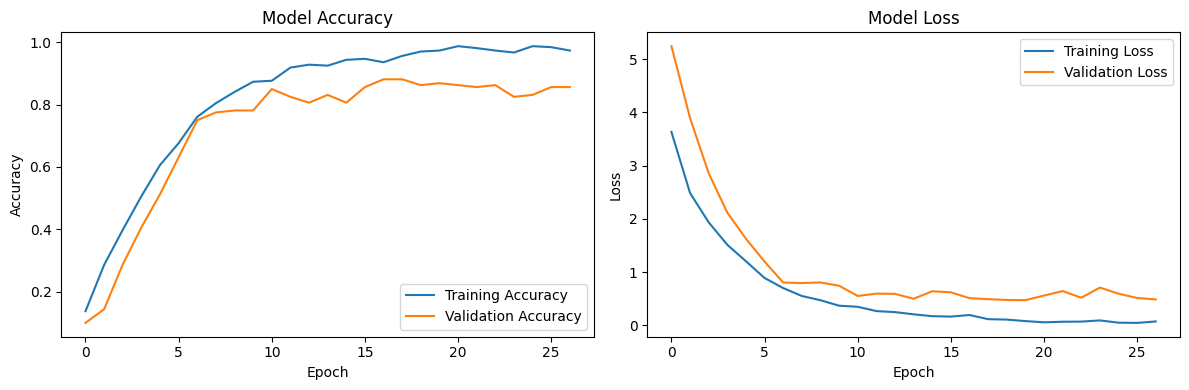

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Model Testing

Evaluates the trained model on test data:
- **Test Data:** `(X_test, y_test)`
- **Output:** Prints the test loss and accuracy

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 470ms/step - accuracy: 0.8497 - loss: 0.4726
Test Loss: 0.3963068425655365
Test Accuracy: 0.875


### Model Predictions

Generates predictions on the test data:
- **Test Data:** `(X_test)`
- **Output:** Predicted values for the test data

In [ ]:
predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 306ms/step


### Visualizing Predictions with Labels

Displays a grid of up to 50 test images, showing predicted and actual labels:
- **Imports:** `matplotlib.pyplot`, `numpy`
- **Plot:** Displays each test image in a 5x10 grid with:
  - **Green Label:** Correct prediction
  - **Red Label:** Incorrect prediction

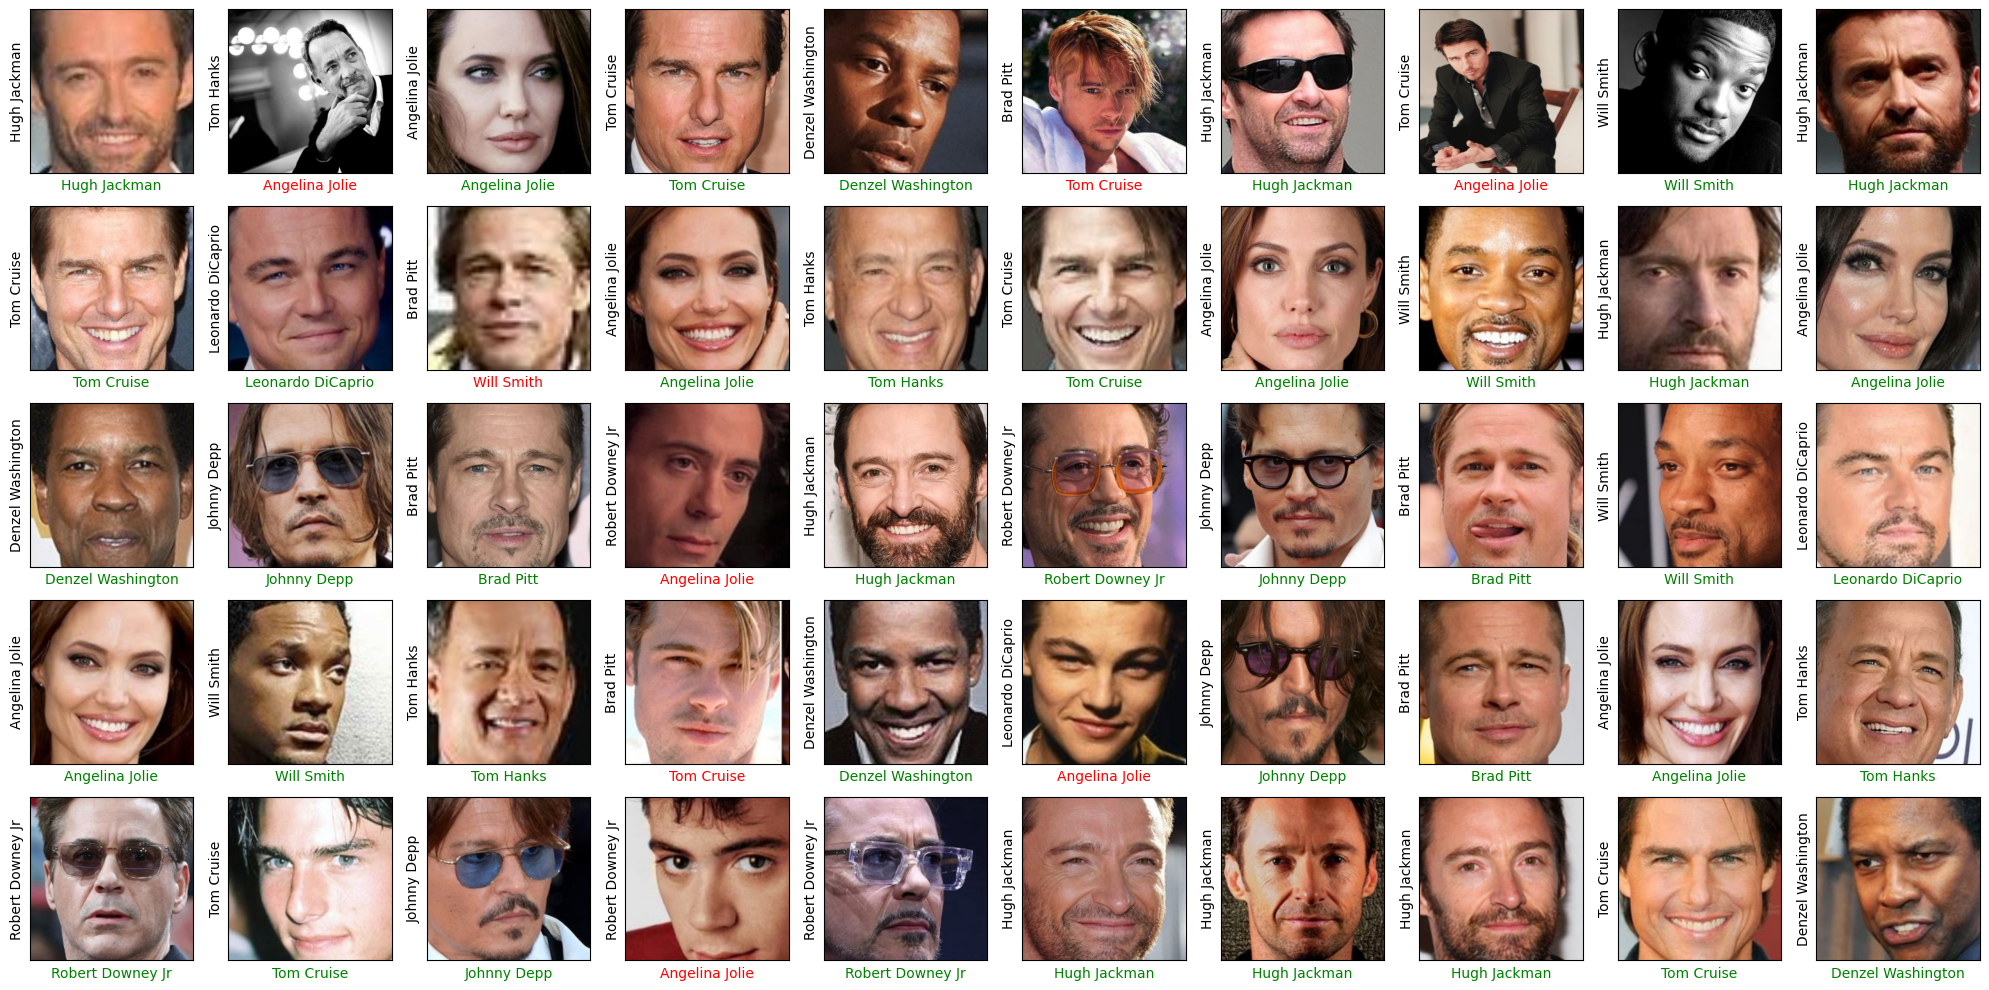

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))

num_samples = min(len(X_test), 50)

for i in range(num_samples):
    plt.subplot(5, 10, i+1)
    plt.imshow(X_test[i].astype(np.uint8))
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(categories[y_test[i]])

    if y_test[i] == np.argmax(predictions[i]):
        plt.xlabel(categories[np.argmax(predictions[i])], color='g')
    else:
        plt.xlabel(categories[np.argmax(predictions[i])], color='r')

plt.tight_layout()
plt.show()
